# Import Modules

In [1]:
# モジュールをインポート
from PyAstronomy.pyasl import SWEETCat
import numpy as np
from numpy import random as rd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from importlib import reload
import warnings

import StarFeature
import PlanetFeature
import Join

warnings.filterwarnings('ignore')

/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
%matplotlib inline

In [3]:
%matplotlib notebook

# Preprocessing

## Reading Files

In [2]:
# データの読み出し
excel_book = pd.ExcelFile('/Users/shohei/Desktop/Shohei/Fresnel/Formation/dataset.xlsx')
df_raw = excel_book.parse('all')
sweet_cat = SWEETCat().data

# データが2つあるものの古い方を削除
sweet_cat = sweet_cat.drop(166)

Saved data to file:  pyasl/resBased/sweetcat.csv.gz  in data directory,
  which has been configured as:  /Users/shohei/Desktop/Shohei/Fresnel/Formation/PyAData
By default, the data will be downloaded anew every 7 days.
You can use the `changeDownloadCycle` to change this behavior.


## Columns Select

In [3]:
# 必要なカラムを取得
df_selected = df_raw[['# name',
                      'Mp',
                      'SEMI',
                      'ECC',
                      'star_name',
                      'Term_year',
                      'Accuracy'
                     ]]

In [4]:
# カラム名を変換
df_selected = df_selected.rename(columns={'# name': 'planet',
                                          'SEMI': 'a',
                                          'ECC': 'e',
                                          'star_name': 'star',
                                          'Term_year': 'Term',
                                          'Accuracy': 'RMS',
                                         })
sweet_cat = sweet_cat.rename(columns={'vt': 'K',
                                      'ervt': 'dK',
                                      'mass': 'Ms'
                                     })

In [6]:
# SWEET-Catカタログから主星の質量と金属量のデータを取得
df_selected = pd.merge(df_selected, sweet_cat[['star', 'K', 'Ms', 'metal', 'author']], on='star', how='left')

In [7]:
# 残ったカラム名を表示
df_selected.columns

Index(['planet', 'Mp', 'a', 'e', 'star', 'Term', 'RMS', 'K', 'Ms', 'metal',
       'author'],
      dtype='object')

## Values Complement

In [8]:
# 'planet'がない行を削除
df_selected = df_selected[df_selected.planet.isnull()==False]

In [9]:
## 異端な惑星を削除
#df_selected = df_selected[df_selected.planet!='24 Boo b']

In [10]:
# 'star'がないものに'planet'を代入
df_selected.star = df_selected.apply(lambda x: x[['star']].fillna(x['planet']), axis=1)

In [11]:
# インデックスに'star'と'planet'を採用したDFを作成
df = df_selected.set_index(['star', 'planet'])

In [12]:
# '~'を'NaN'に変換
df[df=='~'] = np.nan

In [13]:
# 各カラムのいずれかに'NaN'が含まれている行を削除
df = df.dropna(subset=['Mp', 'a', 'e', 'Term', 'RMS', 'K', 'Ms', 'metal'])

In [14]:
## 各カラムの'NaN'に0を代入
#df = df.fillna(0)

In [84]:
# 数値データのものでobject型のものをfloat型に変換
num_columns = ['Mp', 'a', 'e', 'Term', 'RMS', 'K', 'Ms', 'metal']
df[num_columns] = df[num_columns].values.astype(float)

## Check for NULL Data

In [15]:
# nullが含まれているか確認
df.isnull().sum()

Mp        0
a         0
e         0
Term      0
RMS       0
K         0
Ms        0
metal     0
author    0
dtype: int64

# Data Explanation

## Correlation diagram of each column

<Figure size 720x504 with 0 Axes>

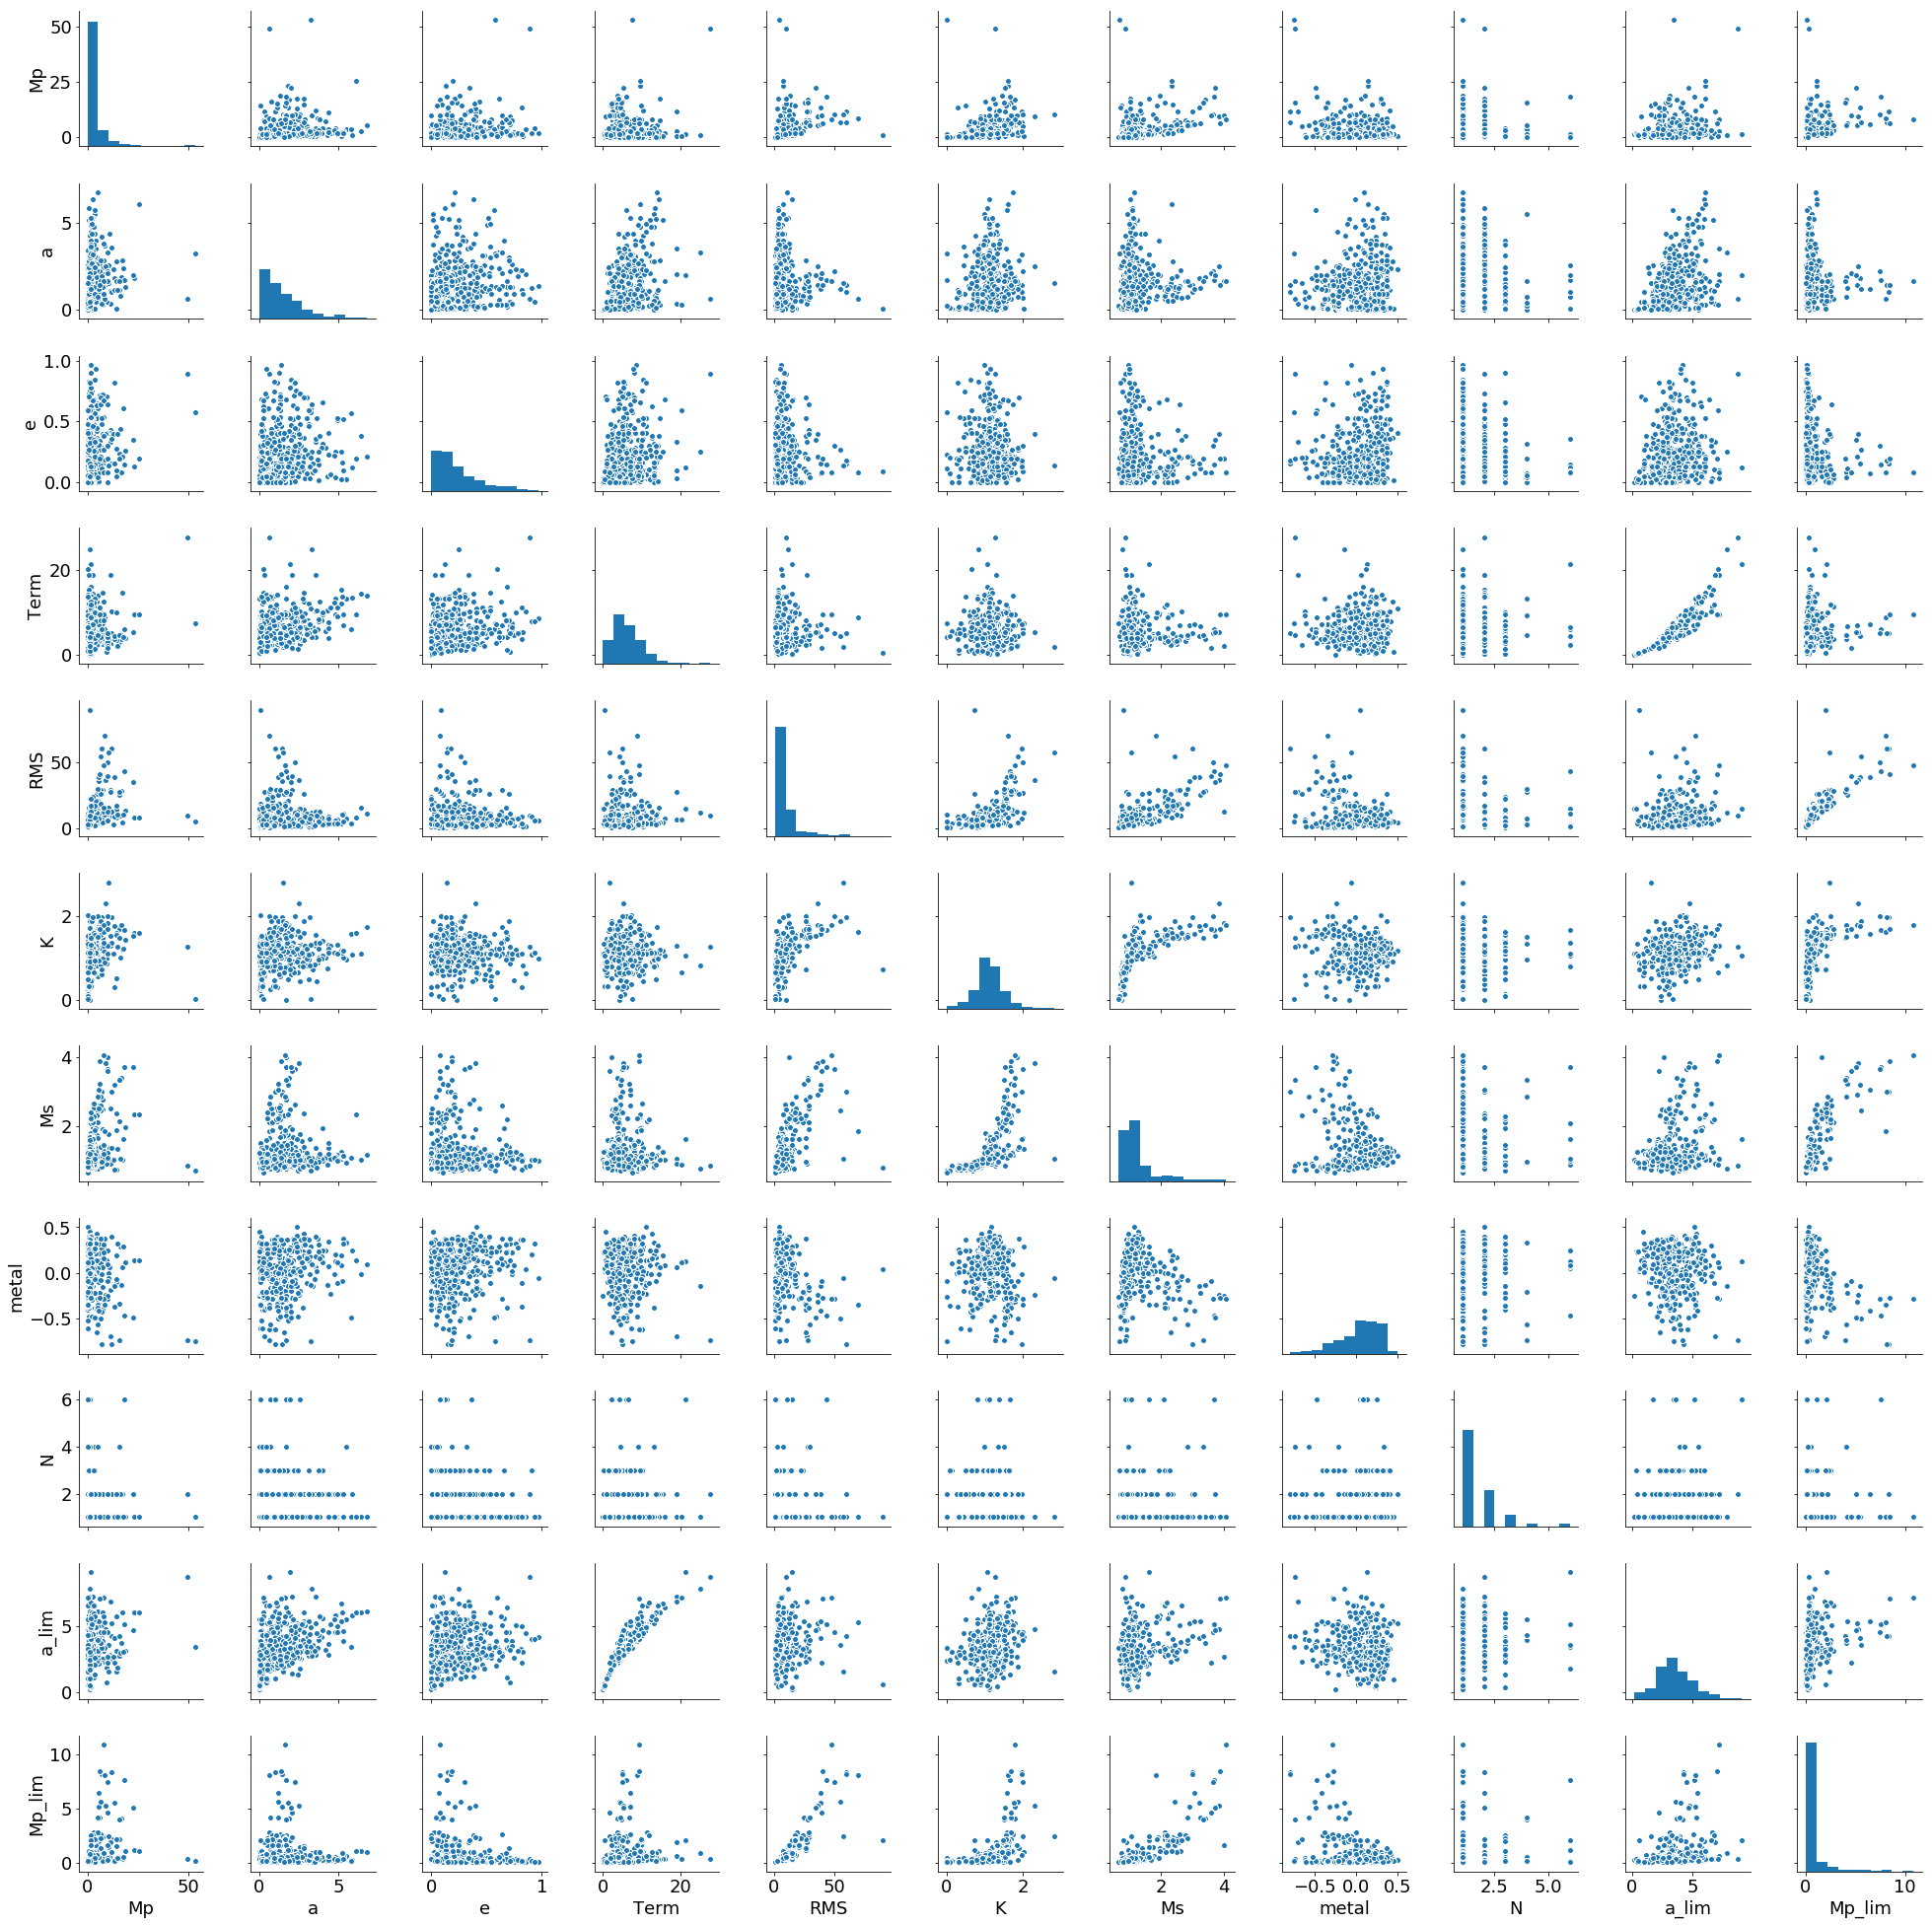

In [32]:
# カラム同士の相関図
plt.figure(figsize=(10, 7))
plt.rcParams['font.size'] = 18
sns.pairplot(df)
plt.show()

# Features Select

In [6]:
# モジュールの再読み込み
reload(StarFeature)
reload(PlanetFeature)
reload(Join)

<module 'Join' from '/Users/shohei/Desktop/Shohei/Python/Paper/Formation/Join.py'>

In [7]:
# 特徴量を抽出し、標準化
X = Join.Join(df).extract(df.drop(df.columns, axis=1))
X_std = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

# Clustering

In [10]:
# グラフ用の名前の辞書を作成
columns = {'Ms':'Ms', 'metal':'metal', 'Mp':'Mp', 'K':'K', 'P':'P', 'a':'a'}
labels = {'Ms':'Star Mass ($\it{M_◉}$)', 'metal':'Host-star Metalicity [Fe/H] (dex)',
          'Mp':'Lower Limit of Companion Mass ($\it{M_{J}}$)', 'K':'Radial Velocity (m/s)',
          'P':'Orbital Period (sec)', 'a':'Semi-Major Axis (AU)'}

In [11]:
def plot2D(model, X, x_name=None, y_name=None, xlogscale=False, ylogscale=False, title=None):
    # 惑星のmetalicityとmassの散布図
    y_model = model.fit_predict(X)
    x = df[[columns[x_name]]].values
    y = df[[columns[y_name]]].values
    plt.figure(figsize=(13, 7))
    if xlogscale:
        plt.xscale('log')
    if ylogscale:
        plt.yscale('log')
    plt.scatter(x[y_model==0], y[y_model==0], s=20, c='orange', marker='o', label='cluster 1')
    plt.scatter(x[y_model==1], y[y_model==1], s=20, c='green', marker='o', label='cluster 2')
    plt.scatter(x[y_model==2], y[y_model==2], s=20, c='cyan', marker='o', label='cluster 3')
    plt.scatter(x[y_model==3], y[y_model==3], s=20, c='blue', marker='o', label='cluster 4')
    plt.scatter(x[y_model==4], y[y_model==4], s=20, c='purple', marker='o', label='cluster 5')
    plt.title(title)
    plt.xlabel(labels[x_name])
    plt.ylabel(labels[y_name])
    plt.legend(loc='upper right', bbox_to_anchor=(1.05, 0.7, 0.3, .100), borderaxespad=0.,)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [12]:
def plot3D(model, X, x_name=None, y_name=None, z_name=None, xlogscale=False, ylogscale=False, zlogscale=False, title=None):
    # 惑星のmetalicityとmassとsemi-mejor axisの散布図
    y_model = model.fit_predict(X)
    x = df[[columns[x_name]]].values
    y = df[[columns[y_name]]].values
    z = df[[columns[z_name]]].values
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_zscale('log')
    ax.scatter3D(x[y_model==0], y[y_model==0], z[y_model==0], s=20, c='orange', marker='o', label='cluster 1')
    ax.scatter3D(x[y_model==1], y[y_model==1], z[y_model==1], s=20, c='green', marker='o', label='cluster 2')
    ax.scatter3D(x[y_model==2], y[y_model==2], z[y_model==2], s=20, c='cyan', marker='o', label='cluster 3')
    ax.scatter3D(x[y_model==3], y[y_model==3], z[y_model==3], s=20, c='blue', marker='o', label='cluster 4')
    ax.scatter3D(x[y_model==4], y[y_model==4], z[y_model==4], s=20, c='purple', marker='o', label='cluster 5')
    ax.set_title(title)
    ax.set_xlabel(labels[x_name])
    ax.set_ylabel(labels[y_name])
    ax.set_zlabel(labels[z_name])
    plt.legend(loc='upper right', bbox_to_anchor=(1.05, 0.7, 0.3, .100), borderaxespad=0.,)
    plt.grid()
    plt.tight_layout()
    plt.show()

## K-means Clustering

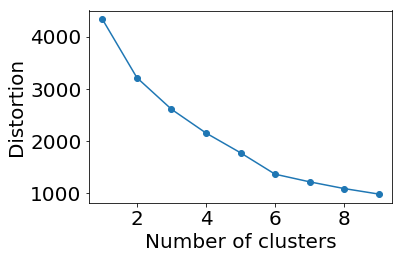

In [13]:
# エルボー法でクラスターの最適個数を確認
distortions = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(X_std)
    distortions.append(km.inertia_)

plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

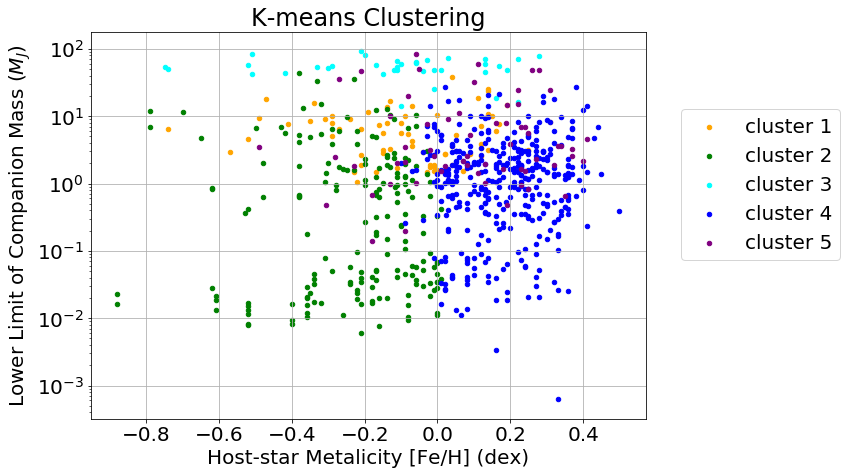

In [29]:
km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, random_state=0)
plot2D(km, X_std, x_name='metal', y_name='Mp', ylogscale=True, title='K-means Clustering')

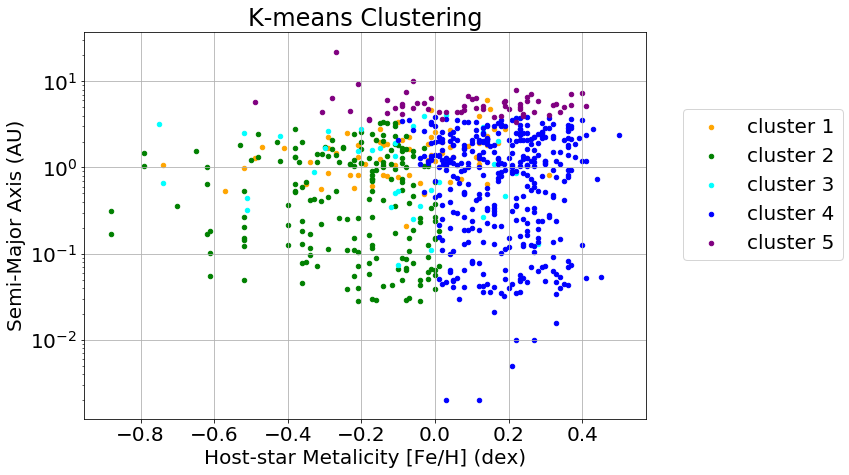

In [28]:
km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, random_state=0)
plot2D(km, X_std, x_name='metal', y_name='a', ylogscale=True, title='K-means Clustering')

## Agglometative Clustering

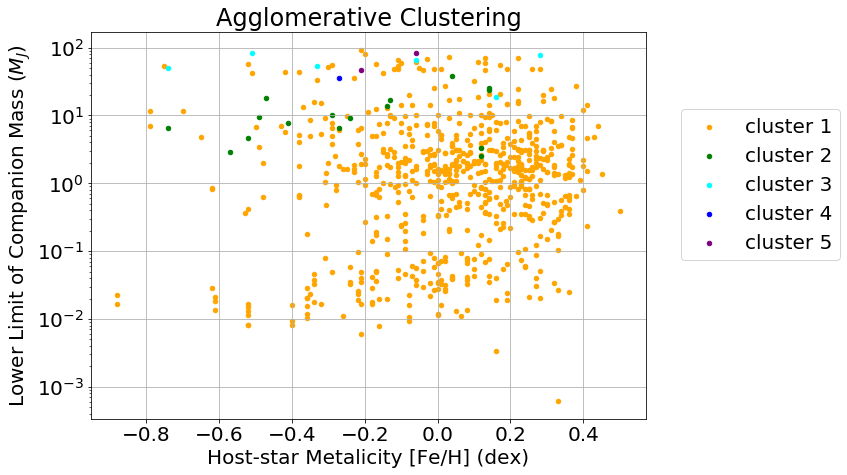

In [27]:
ac = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
plot2D(ac, X_std, x_name='metal', y_name='Mp', ylogscale=True, title='Agglomerative Clustering')

## DBSCAN Clustering

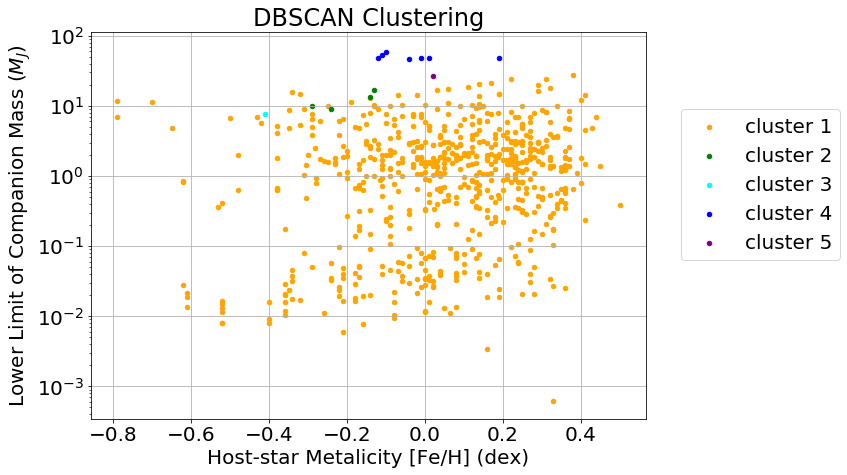

In [30]:
db = DBSCAN(eps=1.0, min_samples=1, metric='euclidean')
plot2D(db, X_std, x_name='metal', y_name='Mp', ylogscale=True, title='DBSCAN Clustering')

# Cluster Analysis

## Cluster map by parameters

In [24]:
# クラスター番号をカラムに追加
def merge(model):
    label = model.labels_
    label_data = pd.DataFrame(label, index=df.index, columns=['cl_nm'])
    return pd.concat([df, label_data], axis=1)

df_merge = merge(km)

In [25]:
def cut_params(data, bins, param):
    param_cut = pd.cut(data, bins, right=False)
    df_merge_param_cl = pd.concat([df_merge.cl_nm, param_cut] ,axis=1)
    df_param_cl = pd.pivot_table(df_merge_param_cl,
                                 index=['cl_nm'],
                                 columns=[param],
                                 aggfunc=lambda x: len(x),
                                 fill_value=0
                                )
    plt.figure(figsize=(10, 7))
    plt.title('Probability Heatmap')
    sns.heatmap(df_param_cl.apply(lambda x: x/sum(x), axis=1), cmap="Blues")

<IPython.core.display.Javascript object>


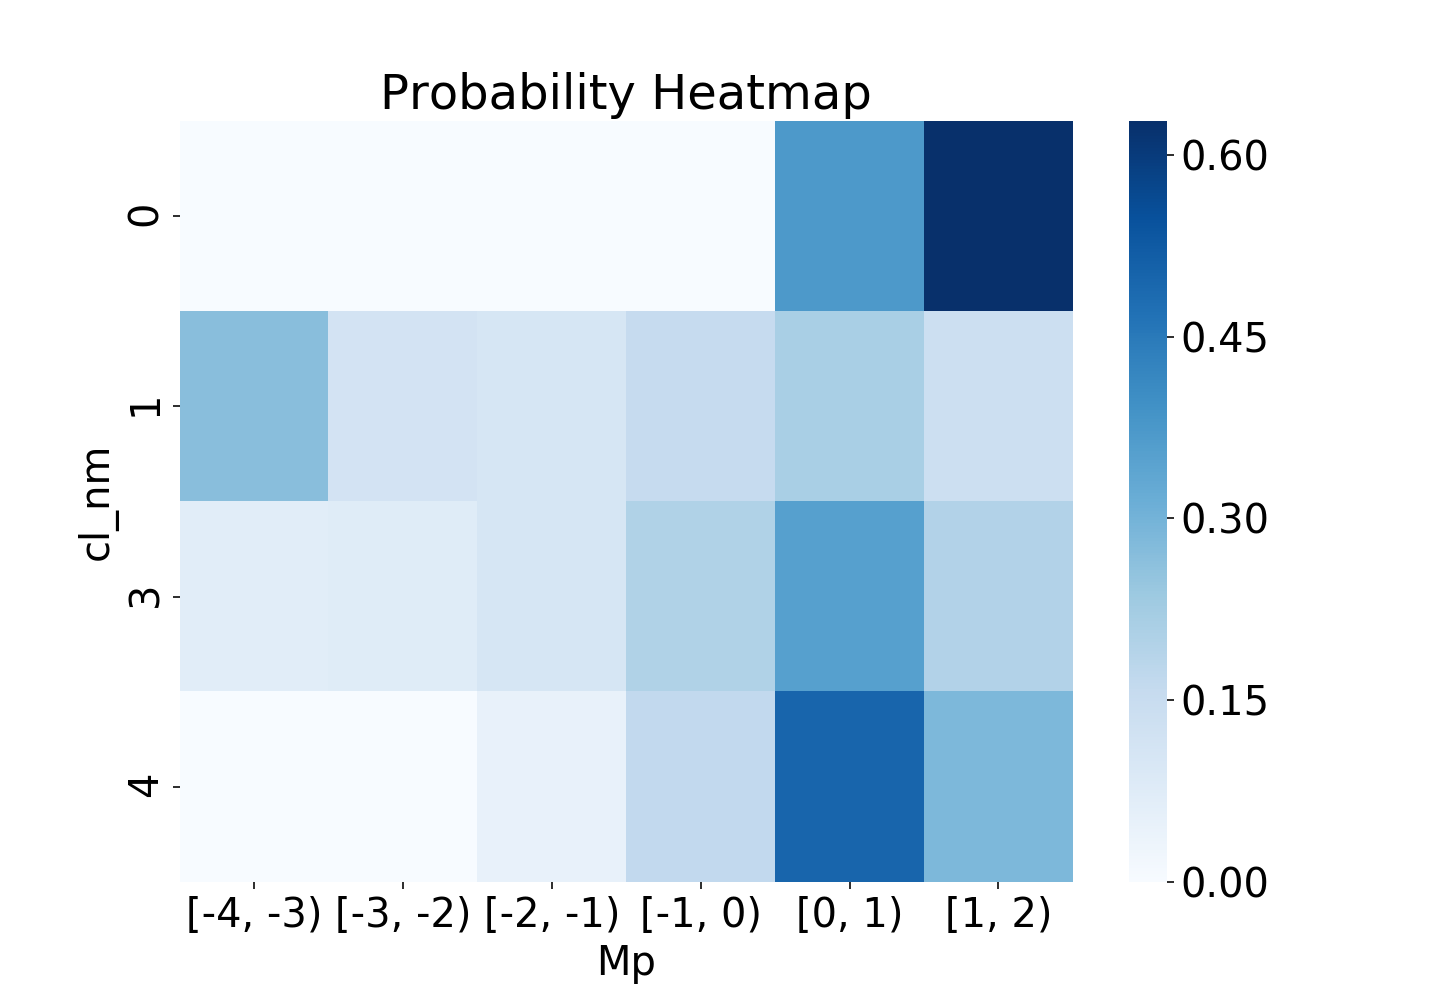

In [26]:
Mp_bins = [-4, -3, -2, -1, 0, 1, 2]
cut_params(np.log(df_merge.Mp), Mp_bins, 'Mp')

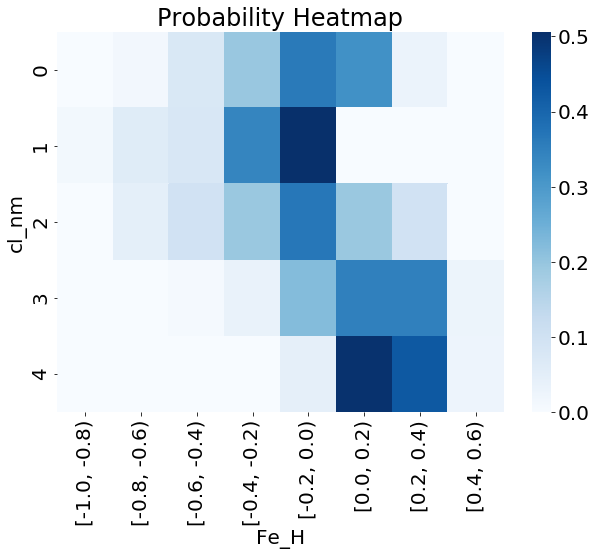

In [22]:
metal_bins = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]
cut_params(df_merge.Fe_H, metal_bins, 'Fe_H')

<IPython.core.display.Javascript object>


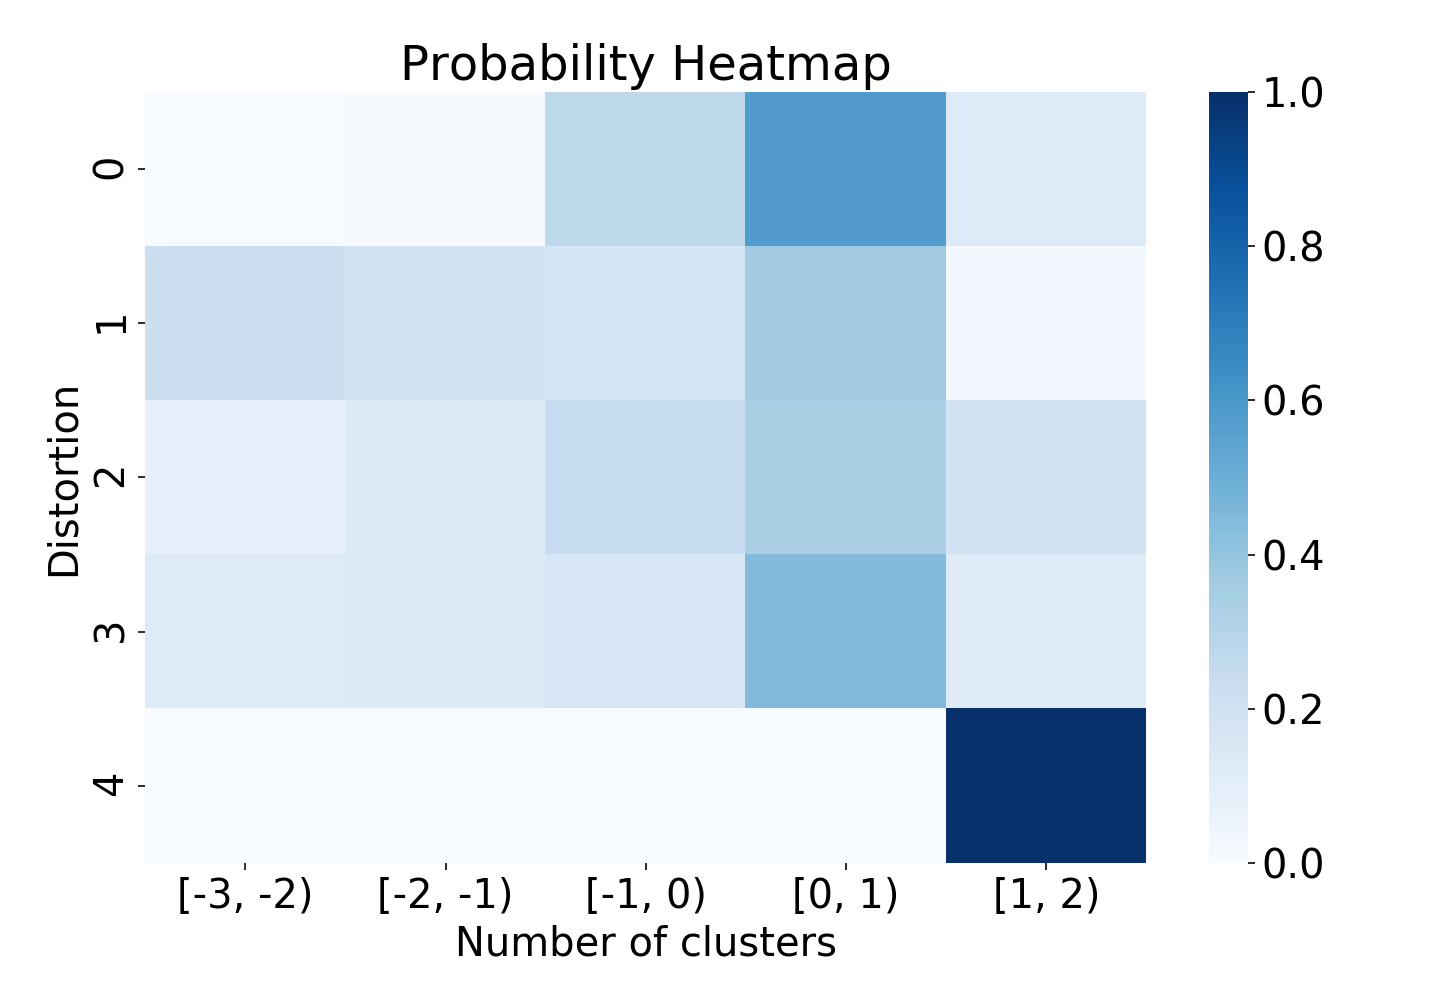

In [27]:
a_bins = [-3, -2, -1, 0, 1, 2]
cut_params(np.log(df_merge.a), a_bins, 'a')